<a href="https://www.kaggle.com/code/hnaw257/facerecognition-task3-tunning-pca?scriptVersionId=164414823" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import fetch_lfw_people 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, funneled=False) 
  
n_samples, h, w = lfw_people.images.shape 
  
X = lfw_people.data 
n_features = X.shape[1] 
  
y = lfw_people.target 
target_names = lfw_people.target_names 
n_classes = target_names.shape[0] 
  
# Print Details about dataset 
print("Number of Data Samples: % d" % n_samples) 
print("Size of a data sample: % d" % n_features) 
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  1288
Size of a data sample:  2914
Number of Class Labels:  7


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y) 

In [6]:
n_components = 150
  
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Euclidean

In [7]:
y_predict = []
for i in range(len(X_test_reduced)):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_predict.append(y_train[min_])

In [8]:
print(classification_report(y_test, y_predict, target_names = target_names)) 

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.48      0.54      0.51        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.61       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.37      0.39      0.38        36

         accuracy                           0.48       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.46      0.48      0.46       322



****

**Set up dataframe for model results storage**

In [9]:
model_scores = {}
prediction_results = {}

*****

# PCA - TUNNING PROCESS

In [12]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Support Vector Machine 

**Normal**

In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.7763975155279503
recall: 0.6928298348777513
precision: 0.7280811673759715
f1-score: 0.702194283540164
roc_auc:  0.8256071901072425


**Tunning**

In [14]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }
    
    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'SVM'
model_scores[model_name] = [accuracy,recall,f1,precision,roc_auc_macro]

[I 2024-02-26 13:51:53,159] A new study created in memory with name: no-name-f517a61a-a1b5-47f7-84e0-9ecad6c7b1c7
[I 2024-02-26 13:51:53,796] Trial 0 finished with value: 0.593162758399658 and parameters: {'kernel': 'poly', 'C': 2121.0401907527844, 'gamma': 0.05186974018411297, 'tol': 0.0028726848520721922, 'shrinking': True}. Best is trial 0 with value: 0.593162758399658.
[I 2024-02-26 13:51:54,244] Trial 1 finished with value: 0.7494791944874739 and parameters: {'kernel': 'linear', 'C': 1859.2993373362372, 'gamma': 10691.904994513872, 'tol': 0.004569173658456617, 'shrinking': True}. Best is trial 1 with value: 0.7494791944874739.
[I 2024-02-26 13:51:54,952] Trial 2 finished with value: 0.593162758399658 and parameters: {'kernel': 'poly', 'C': 0.0007796790995027344, 'gamma': 90272.27752207703, 'tol': 0.0003855474968340701, 'shrinking': True}. Best is trial 1 with value: 0.7494791944874739.
[I 2024-02-26 13:51:55,281] Trial 3 finished with value: 0.4182255221409113 and parameters: {'ke

Best params found : {'kernel': 'linear', 'C': 0.08897324346100909, 'gamma': 2312.3714130350404, 'tol': 0.002971839753912022, 'shrinking': False}
accuracy: 0.8260869565217391
recall: 0.7132956820353277
precision: 0.804576092571862
f1-score: 0.7466142978930703
roc_auc:  0.8391675488636123


In [16]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

SVM

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.63      0.73        19
     Colin Powell       0.87      0.88      0.87        59
  Donald Rumsfeld       0.82      0.77      0.79        30
    George W Bush       0.84      0.93      0.89       133
Gerhard Schroeder       0.77      0.63      0.69        27
      Hugo Chavez       0.73      0.44      0.55        18
       Tony Blair       0.78      0.86      0.82        36

         accuracy                           0.83       322
        macro avg       0.81      0.74      0.76       322
     weighted avg       0.83      0.83      0.82       322



# Decision Tree

**Normal**

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.38198757763975155
recall: 0.25218157041783906
precision: 0.25456901336730464
f1-score: 0.2501394804026383
roc_auc:  0.5668719892430257
accuracy: 0.7763975155279503
recall: 0.6928298348777513
precision: 0.7280811673759715
f1-score: 0.702194283540164
roc_auc:  0.8256071901072425


**Tunning**

In [18]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])

    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Decision Tree'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-26 13:52:43,531] A new study created in memory with name: no-name-9f30810a-8dfd-449f-9c5c-3e948c946cda
[I 2024-02-26 13:52:43,919] Trial 0 finished with value: 0.37781635596389085 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.37781635596389085.
[I 2024-02-26 13:52:44,755] Trial 1 finished with value: 0.3923294695796165 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9, 'criterion': 'entropy', 'random_state': 42}. Best is trial 1 with value: 0.3923294695796165.
[I 2024-02-26 13:52:45,544] Trial 2 finished with value: 0.4120239303456012 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'entropy', 'random_state': 42}. Best is trial 2 with value: 0.4120239303456012.
[I 2024-02-26 13:52:45,908] Trial 3 finished with value: 0.39437530046471875 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_

Best params found : {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'entropy', 'random_state': 42}
accuracy: 0.4254658385093168
recall: 0.29441130402007165
precision: 0.4532837403581552
f1-score: 0.3007635746421083
roc_auc:  0.5897933600654229


In [20]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Decision Tree

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.63      0.73        19
     Colin Powell       0.87      0.88      0.87        59
  Donald Rumsfeld       0.82      0.77      0.79        30
    George W Bush       0.84      0.93      0.89       133
Gerhard Schroeder       0.77      0.63      0.69        27
      Hugo Chavez       0.73      0.44      0.55        18
       Tony Blair       0.78      0.86      0.82        36

         accuracy                           0.83       322
        macro avg       0.81      0.74      0.76       322
     weighted avg       0.83      0.83      0.82       322



# KNN Classifier

**Normal**

In [54]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.5279503105590062
recall: 0.38469633864052105
precision: 0.5699902581342056
f1-score: 0.3860498867563558
roc_auc:  0.6456621374560096


**Tunning**

In [55]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [56]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'K-Nearest Neighbors'
model_scores[model_name] = [accuracy, recall, f1,precision, roc_auc_macro]

[I 2024-02-26 14:25:43,889] A new study created in memory with name: no-name-e067e341-1751-4ba4-a631-0d92ef0512e1
[I 2024-02-26 14:25:44,140] Trial 0 finished with value: 0.4585866139629293 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.4585866139629293.
[I 2024-02-26 14:25:44,332] Trial 1 finished with value: 0.46167939746808395 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.46167939746808395.
[I 2024-02-26 14:25:44,570] Trial 2 finished with value: 0.4917686021045885 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.4917686021045885.
[I 2024-02-26 14:25:44,771] Trial 3 finished with value: 0.46479888894823995 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Be

Best params found : {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'kd_tree'}
accuracy: 0.5869565217391305
recall: 0.40885850623329917
precision: 0.48353432282003705
f1-score: 0.4255772941382915
roc_auc:  0.6612754504963368


In [24]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

K-Nearest Neighbors

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.63      0.73        19
     Colin Powell       0.87      0.88      0.87        59
  Donald Rumsfeld       0.82      0.77      0.79        30
    George W Bush       0.84      0.93      0.89       133
Gerhard Schroeder       0.77      0.63      0.69        27
      Hugo Chavez       0.73      0.44      0.55        18
       Tony Blair       0.78      0.86      0.82        36

         accuracy                           0.83       322
        macro avg       0.81      0.74      0.76       322
     weighted avg       0.83      0.83      0.82       322



****

# Gaussian NB

**Pre-tunning**

In [25]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.6925465838509317
recall: 0.5947805348722897
precision: 0.6703009828009828
f1-score: 0.6152952508967625


**Tunning**

In [26]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [27]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Gaussian Naives Bayes'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-26 13:53:41,804] A new study created in memory with name: no-name-7096d894-06b1-461c-ab8e-43d2076b5f66
[I 2024-02-26 13:53:41,833] Trial 0 finished with value: 0.6304524330965227 and parameters: {'var_smoothing': 3.4245908887022284e-08}. Best is trial 0 with value: 0.6304524330965227.
[I 2024-02-26 13:53:41,859] Trial 1 finished with value: 0.6304524330965227 and parameters: {'var_smoothing': 2.374702520835408e-08}. Best is trial 0 with value: 0.6304524330965227.
[I 2024-02-26 13:53:41,884] Trial 2 finished with value: 0.6304524330965227 and parameters: {'var_smoothing': 2.1667841779711388e-06}. Best is trial 0 with value: 0.6304524330965227.
[I 2024-02-26 13:53:41,909] Trial 3 finished with value: 0.6304524330965227 and parameters: {'var_smoothing': 1.1762169792777511e-08}. Best is trial 0 with value: 0.6304524330965227.
[I 2024-02-26 13:53:41,935] Trial 4 finished with value: 0.6304524330965227 and parameters: {'var_smoothing': 1.774118796377589e-07}. Best is trial 0 with 

Best params found : {'var_smoothing': 7.285925863731868e-05}
accuracy: 0.6925465838509317
recall: 0.5919108370873377
precision: 0.6780936721103866
f1-score: 0.6147778217024922
roc_auc:  0.7661557648117571


In [ ]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

****

# Logistic Regression

**Normal**

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

**Tunning**

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [31]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Logistic Regression'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-26 13:53:49,823] Trial 1 finished with value: 0.7815714972490786 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.5159769224423136}. Best is trial 1 with value: 0.7815714972490786.
[I 2024-02-26 13:53:52,986] Trial 2 finished with value: 0.7670744084183537 and parameters: {'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.4828093497562417}. Best is trial 1 with value: 0.7815714972490786.
[I 2024-02-26 13:53:53,626] Trial 3 finished with value: 0.7422306500721115 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 568.6041754951932}. Best is trial 1 with value: 0.7815714972490786.
[I 2024-02-26 13:53:53,884] Trial 4 finished with value: 0.6728700389936435 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.03011862632244709}. Best is trial 1 with value: 0.7815714972490786.
[I 2024-02-26 13:53:57,239] Trial 5 finished with value: 0.7743389776187168 and parameters: {'sol

Best params found : {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.9682512427405446}
accuracy: 0.8291925465838509
recall: 0.7353025083559047
precision: 0.8091107871720117
f1-score: 0.7630616005329232
roc_auc:  0.8509282952176332


In [32]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Logistic Regression

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.63      0.73        19
     Colin Powell       0.87      0.88      0.87        59
  Donald Rumsfeld       0.82      0.77      0.79        30
    George W Bush       0.84      0.93      0.89       133
Gerhard Schroeder       0.77      0.63      0.69        27
      Hugo Chavez       0.73      0.44      0.55        18
       Tony Blair       0.78      0.86      0.82        36

         accuracy                           0.83       322
        macro avg       0.81      0.74      0.76       322
     weighted avg       0.83      0.83      0.82       322



***

# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [34]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.515527950310559
recall: 0.23499325391768364
precision: 0.4257780588715841
f1-score: 0.2155195566636055
roc_auc:  0.5724364359323166


**Tunning**

In [35]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [36]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-26 13:57:43,002] A new study created in memory with name: no-name-c9a62f93-a4b9-416c-9a6f-b7bad07f11b1
[I 2024-02-26 13:57:47,975] Trial 0 finished with value: 0.4233961861011698 and parameters: {'n_estimators': 208, 'max_depth': 43, 'min_samples_split': 8, 'random_state': 42, 'min_samples_leaf': 25}. Best is trial 0 with value: 0.4233961861011698.
[I 2024-02-26 13:57:58,298] Trial 1 finished with value: 0.4410020832220501 and parameters: {'n_estimators': 416, 'max_depth': 29, 'min_samples_split': 2, 'random_state': 42, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.4410020832220501.
[I 2024-02-26 13:58:02,833] Trial 2 finished with value: 0.4233961861011698 and parameters: {'n_estimators': 196, 'max_depth': 27, 'min_samples_split': 11, 'random_state': 42, 'min_samples_leaf': 25}. Best is trial 1 with value: 0.4410020832220501.
[I 2024-02-26 13:58:17,294] Trial 3 finished with value: 0.43582607766679127 and parameters: {'n_estimators': 589, 'max_depth': 21, 'min_samp

Best params found : {'n_estimators': 103, 'max_depth': 39, 'min_samples_split': 3, 'random_state': 42, 'min_samples_leaf': 2}


0.5093167701863354

In [37]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Random Forest'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

accuracy: 0.5093167701863354
recall: 0.22180521926284635
precision: 0.4811507936507936
f1-score: 0.198251685581611
roc_auc:  0.5515088479019743


In [38]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Random Forest

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.63      0.73        19
     Colin Powell       0.87      0.88      0.87        59
  Donald Rumsfeld       0.82      0.77      0.79        30
    George W Bush       0.84      0.93      0.89       133
Gerhard Schroeder       0.77      0.63      0.69        27
      Hugo Chavez       0.73      0.44      0.55        18
       Tony Blair       0.78      0.86      0.82        36

         accuracy                           0.83       322
        macro avg       0.81      0.74      0.76       322
     weighted avg       0.83      0.83      0.82       322



****

****

# SUMMARY

**Classification over all models**

In [57]:
results_df = pd.DataFrame(model_scores, index=['Accuracy', 'Recall','F1 Score','Precision','ROC AUC']).T
results_df

,Accuracy,Recall,F1 Score,Precision,ROC AUC
SVM,0.826087,0.713296,0.746614,0.804576,0.839168
Decision Tree,0.425466,0.294411,0.300764,0.453284,0.589793
K-Nearest Neighbors,0.586957,0.408859,0.425577,0.483534,0.661275
Gaussian Naives Bayes,0.692547,0.591911,0.614778,0.678094,0.766156
Logistic Regression,0.829193,0.735303,0.763062,0.809111,0.850928
Random Forest,0.509317,0.221805,0.198252,0.481151,0.551509


In [43]:
# dump prediction results
# import json
# with open("/kaggle/working/predict.json", "w") as json_file:
#     json.dump(prediction_results, json_file)

****
## Visualization

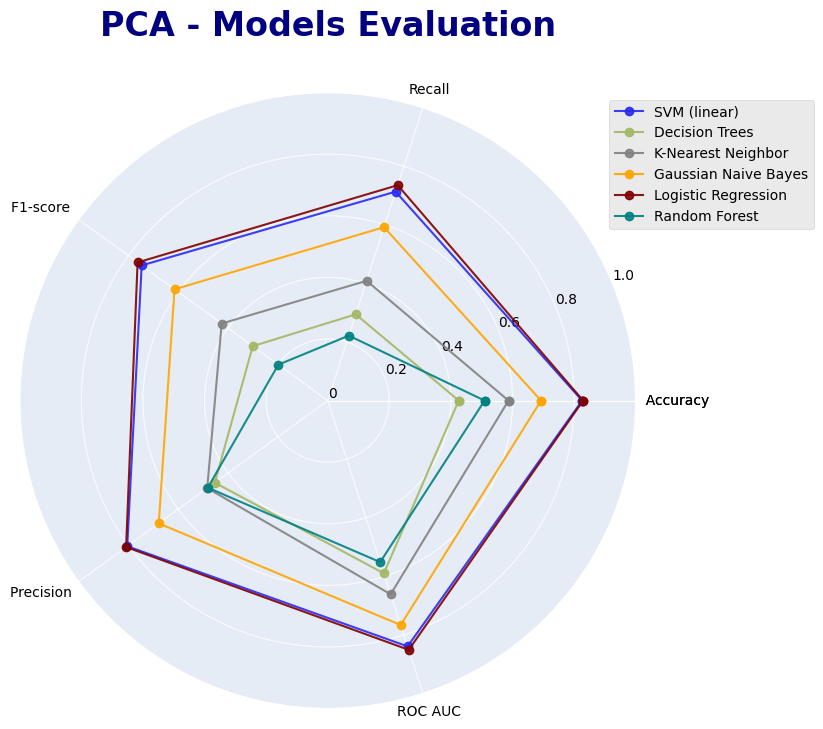

In [64]:
plt.style.use('ggplot')
# Data
labels = [(' '*10 +'Accuracy'), 'Recall', ('F1-score'+ ' ' * 10) , ('Precision'+ ' ' * 10), 'ROC AUC']
svm = results_df.loc['SVM'].tolist()
dt = results_df.loc['Decision Tree'].tolist()
knn = results_df.loc['K-Nearest Neighbors'].tolist()
gnb = results_df.loc['Gaussian Naives Bayes'].tolist()
lr = results_df.loc['Logistic Regression'].tolist()
rf = results_df.loc['Random Forest'].tolist()

# Number of variables we're plotting.
categories = labels
N = len(categories)

# What will be the angle of each axis in the plot?
angles = np.linspace(0, 2*np.pi, len(labels), endpoint = False)
angles = np.concatenate((angles, [angles[0]]))


# Initialise the spider plot
plt.figure(figsize=(8, 8))  # Increase the size of the radar

# Draw one axe per variable + add labels yet
plt.xticks(angles[:-1], categories, color='white')  # White labels
plt.yticks([i/10 for i in range(11)], ["{:.2f}".format(i/10) for i in range(11)], color="white", size=7)
plt.ylim(0, 1)

# Set gray background
ax = plt.subplot(111, polar=True, facecolor='#E6ECF5', alpha = 0.7)  

# Plot each classifier's data
for data, label, color in zip([svm, dt, knn, gnb, lr, rf],
                              ["SVM (linear)", "Decision Trees", "K-Nearest Neighbor",
                               "Gaussian Naive Bayes", "Logistic Regression", "Random Forest"],
                              ['#292AF4', '#A3B763', '#818181', 'orange', 'maroon', 'teal']):
 
    ax.plot(angles, data + data[:1], 'o-', linewidth=1.5, label=label, color=color, alpha = 0.9)
    ax.fill(angles, data + data[:1], alpha=0)  # Fill only the edges
    
# Modify grids
labels.append(labels[0])
ax.set_thetagrids(angles * 180/np.pi, labels, color = 'black')
plt.grid(True)

# Add labels for each coordinate system
# for angle, lab in zip(angles, labels):
# plt.annotate(labels[0], xy=(angles[0], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[1], xy=(angles[1], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[2], xy=(angles[2], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[3], xy=(angles[3], 1.1), color='white', fontsize=10, ha='center')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("PCA - Models Evaluation\n", size = 24,color='navy', weight = 'bold')
plt.grid(color='white', linestyle='-', alpha = 0.8)  # White grid lines
plt.yticks([0,0.2, 0.4, 0.6, 0.8, 1.0], ["0","0.2", "0.4", "0.6", "0.8", "1.0"],color="black", size=10)  # Custom y-ticks
plt.show()


In [60]:
# dump prediction results
import json
predictions = {}
for k in prediction_results.keys():
    predictions[k] = list(prediction_results[k])

# with open("/kaggle/working/prediction_results.json", "w") as json_file:
#     json.dump(predictions, json_file)

predictions

{'svc': [1,
  1,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  1,
  3,
  0,
  6,
  5,
  3,
  3,
  3,
  5,
  4,
  3,
  3,
  2,
  1,
  4,
  3,
  1,
  1,
  3,
  3,
  1,
  1,
  3,
  2,
  1,
  2,
  4,
  2,
  1,
  1,
  3,
  3,
  1,
  1,
  1,
  3,
  6,
  3,
  2,
  3,
  3,
  3,
  0,
  3,
  1,
  3,
  0,
  3,
  4,
  3,
  3,
  1,
  3,
  3,
  3,
  1,
  3,
  3,
  1,
  6,
  3,
  1,
  3,
  1,
  2,
  3,
  6,
  6,
  3,
  6,
  3,
  3,
  1,
  3,
  1,
  0,
  4,
  2,
  1,
  5,
  3,
  3,
  2,
  6,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  1,
  3,
  3,
  3,
  4,
  3,
  3,
  1,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  6,
  3,
  1,
  6,
  3,
  0,
  1,
  1,
  3,
  2,
  2,
  3,
  3,
  3,
  3,
  5,
  6,
  2,
  2,
  1,
  3,
  3,
  1,
  3,
  0,
  1,
  3,
  3,
  3,
  1,
  2,
  6,
  3,
  6,
  3,
  1,
  1,
  3,
  2,
  2,
  3,
  3,
  3,
  6,
  3,
  3,
  6,
  6,
  3,
  3,
  3,
  3,
  3,
  6,
  3,
  3,
  3,
  2,
  3,
  2,
  3,
  1,
  1,
  3,
  3,
  0,
  1,
  3,
  6,
  2,
  6,
  4,
  4,
  3,
  6,
  0,
  3,
  0,
  2,
  3,
  3,
  4,
  3,
  1